# NNDL HW2_extra

sajjad pakdaman

810195517

## setup


### import

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import cv2
from tqdm import tqdm

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D , MaxPooling2D
from keras.layers.normalization import BatchNormalization

from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras.preprocessing.image import  ImageDataGenerator as IDG


np.random.seed(1234)

Using TensorFlow backend.


### download dataset from [here](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html)

In [0]:
!wget "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip"
!unzip -qq GTSRB-Training_fixed.zip
!wget "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip"
!unzip -qq GTSRB_Final_Test_GT.zip
!wget "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip"
!unzip -qq GTSRB_Final_Test_Images.zip

## data loader

In [0]:
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

def TSreadTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Final_Tets/images/'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    with open('/content/GT-final_test.csv') as gtFile:# annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(rootpath + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
    return images, labels


In [0]:
tr_images , tr_labels = readTrafficSigns('./GTSRB/Training')
ts_images , ts_labels = TSreadTrafficSigns('./GTSRB/Final_Test/Images/')

# make all the images have size(30, 30)
for i , img in enumerate(tr_images):
    tr_images[i] = cv2.resize(img , (30,30))

for i, img in enumerate(ts_images):
    ts_images[i] = cv2.resize(img, (30,30))

## basic data analysis

### class bias

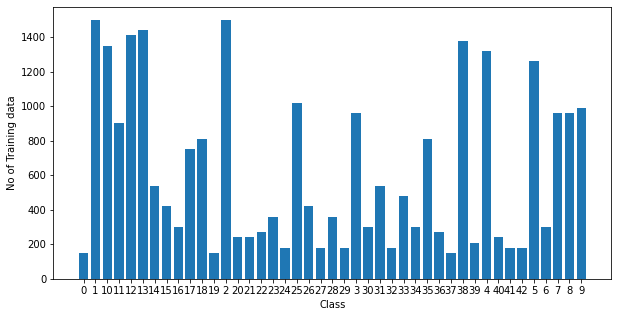

In [4]:
unique_elements, counts_elements = np.unique(sorted(tr_labels), return_counts = True)
plt.figure(figsize=(10 , 5))
plt.bar(unique_elements , counts_elements)
plt.xlabel('Class')
plt.ylabel('No of Training data')

mx_count = max(counts_elements)

some random picks of data set

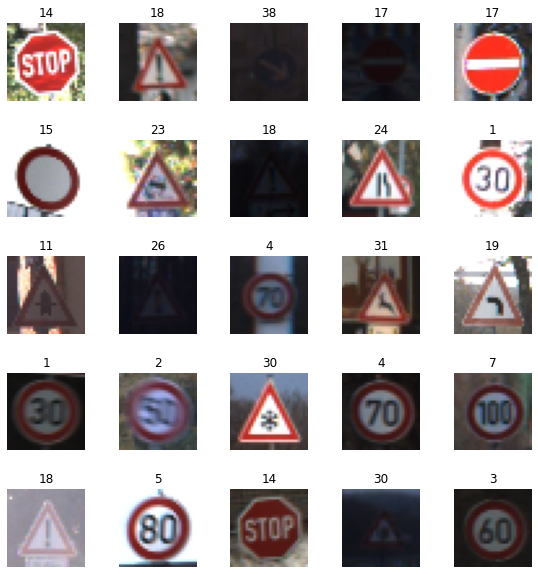

In [5]:
fig, axs = plt.subplots(5,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(25):
    index = random.randint(0, len(tr_images))
    image = tr_images[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(tr_labels[index])

In [0]:
# standard data
tr_images = np.array(tr_images,dtype=np.float32)/255.0
ts_images = np.array(ts_images,dtype=np.float32)/255.0
tr_labels = keras.utils.to_categorical(tr_labels)
ts_labels = keras.utils.to_categorical(ts_labels)

## CNN model

In [0]:
def create_batch_norm_model(n_classes = 43):
  model = Sequential()
  # layer 1
  model.add(Conv2D(32, kernel_size=(3, 3),activation= 'relu' , input_shape=(30, 30, 3))) # 28x28x32
  model.add(MaxPooling2D(pool_size=(2, 2))) # 14x14x32
  model.add(BatchNormalization())

  #layer 2
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) # 12x12x64
  model.add(MaxPooling2D(pool_size=(2, 2))) # 6x6x64
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  # layer 3
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu')) #4x4x128
  model.add(MaxPooling2D(pool_size=(2, 2))) #2x2x128
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(BatchNormalization())

  #layer 4
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))
  return model

In [0]:
model_batched = create_batch_norm_model()
model_batched.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
batched_history = model_batched.fit(tr_images, tr_labels, validation_data=(ts_images, ts_labels), batch_size=128, epochs = 20)

Train on 26640 samples, validate on 12630 samples
Epoch 1/20
26640/26640 [==============================] - 7s 271us/step - loss: 3.0829 - accuracy: 0.2163 - val_loss: 4.0047 - val_accuracy: 0.0570
Epoch 2/20
26640/26640 [==============================] - 5s 180us/step - loss: 1.5760 - accuracy: 0.5192 - val_loss: 3.7940 - val_accuracy: 0.1429
Epoch 3/20
26640/26640 [==============================] - 5s 179us/step - loss: 0.9359 - accuracy: 0.6961 - val_loss: 0.8383 - val_accuracy: 0.7738
Epoch 4/20
26640/26640 [==============================] - 5s 177us/step - loss: 0.6407 - accuracy: 0.7907 - val_loss: 0.4097 - val_accuracy: 0.8888
Epoch 5/20
26640/26640 [==============================] - 5s 179us/step - loss: 0.4970 - accuracy: 0.8376 - val_loss: 0.3535 - val_accuracy: 0.8937
Epoch 6/20
26640/26640 [==============================] - 5s 179us/step - loss: 0.4036 - accuracy: 0.8700 - val_loss: 0.3058 - val_accuracy: 0.9086
Epoch 7/20
26640/26640 [==============================] - 5s 1

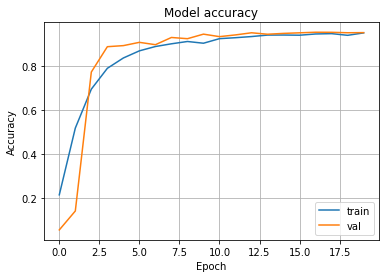

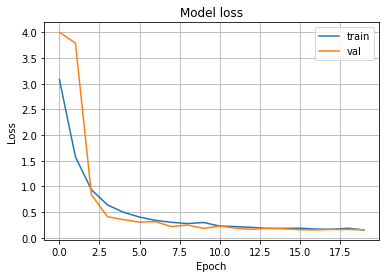

In [10]:
plt.plot(batched_history.history['accuracy'])
plt.plot(batched_history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'])
plt.grid()
plt.show()

plt.plot(batched_history.history['loss'])
plt.plot(batched_history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()



In [0]:
model_batched.trainable = False
model_batched.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model_batched.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 64)         

In [0]:
def SI(X, Y):
    '''
    X is np.ndarray
    Y is np.ndarray
    '''
    print('compute si')
    si = 0
    flat_X = tf.reshape(X, (X.shape[0], -1))
    for i in range(X.shape[0]):
        vals , idxs = tf.math.top_k(-1 * tf.norm(flat_X - flat_X[i] , axis=1), k=2)
        idx = keras.backend.eval(idxs[1])
        if np.linalg.norm(Y[idx]-Y[i]) == 0 :
            si += 1
    return si / X.shape[0]

In [31]:
si = []
temp = tf.convert_to_tensor(ts_images)
si += [SI(keras.backend.eval(temp), ts_labels)]

for i in tqdm(range(len(model_batched.layers))):
    temp = model_batched.layers[i](temp)
    si += [SI(keras.backend.eval(temp), ts_labels)]

compute si






  0%|          | 0/15 [00:00<?, ?it/s]

compute si






  7%|▋         | 1/15 [09:26<2:12:11, 566.51s/it]

compute si






 13%|█▎        | 2/15 [11:54<1:35:31, 440.91s/it]

compute si






 20%|██        | 3/15 [14:22<1:10:36, 353.01s/it]

compute si






 27%|██▋       | 4/15 [17:54<56:59, 310.84s/it]  

compute si






 33%|███▎      | 5/15 [18:55<39:18, 235.89s/it]

compute si






 40%|████      | 6/15 [19:56<27:31, 183.45s/it]

compute si






 47%|████▋     | 7/15 [20:57<19:33, 146.70s/it]

compute si






 53%|█████▎    | 8/15 [21:53<13:55, 119.40s/it]

compute si






 60%|██████    | 9/15 [22:14<08:59, 89.95s/it] 

compute si






 67%|██████▋   | 10/15 [22:35<05:46, 69.34s/it]

compute si






 73%|███████▎  | 11/15 [22:57<03:39, 54.89s/it]

compute si






 80%|████████  | 12/15 [23:18<02:14, 44.91s/it]

compute si






 87%|████████▋ | 13/15 [23:36<01:13, 36.91s/it]

compute si






 93%|█████████▎| 14/15 [23:54<00:31, 31.23s/it]

compute si






100%|██████████| 15/15 [24:12<00:00, 96.86s/it]


In [30]:
temp.shape

TensorShape([12630, 43])

Text(0, 0.5, 'SI')

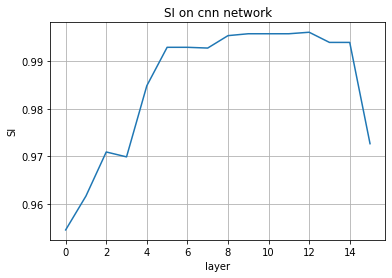

In [34]:
plt.plot(range(len(model_batched.layers)+1) , si)
plt.grid()
plt.title('SI on cnn network')
plt.xlabel('layer')
plt.ylabel('SI')

In [0]:
def cluster_idx(Y, n_classes = 43):
    labels = np.eye(n_classes)
    masks = np.zeros((n_classes, Y.shape[0]), dtype=bool)
    for i, l in enumerate(labels):
        dist = np.linalg.norm(Y-l, axis=1)
        masks[i] = (dist ==0)
    return masks

In [0]:
def SI2(X, Y, masks, n_classes = 43):
    '''
    X is np.ndarray
    Y is np.ndarray
    '''
    
    # compute 
    si = 0
    flat_X = tf.reshape(X, (X.shape[0], -1))
    ms = np.zeros((n_classes, flat_X.shape[1]))

    for i in range(n_classes):
        ms[i] = np.mean(flat_X[masks[i]], axis=0)

    for i in range(X.shape[0]):
        idx = tf.math.argmin(tf.norm(ms - flat_X[i] , axis=1))
        idx = keras.backend.eval(idx)
        if Y[i][idx] == 1:
            si += 1
    return si / X.shape[0]

In [0]:
masks = cluster_idx(ts_labels)

In [89]:
si = []
temp = tf.convert_to_tensor(ts_images)
si += [SI2(keras.backend.eval(temp), ts_labels, masks)]

for i in tqdm(range(len(model_batched.layers))):
    temp = model_batched.layers[i](temp)
    si += [SI2(keras.backend.eval(temp), ts_labels, masks)]





  0%|          | 0/15 [00:00<?, ?it/s]



  7%|▋         | 1/15 [00:38<09:04, 38.86s/it]



 13%|█▎        | 2/15 [01:01<07:22, 34.01s/it]



 20%|██        | 3/15 [01:24<06:06, 30.56s/it]



 27%|██▋       | 4/15 [01:48<05:14, 28.60s/it]



 33%|███▎      | 5/15 [02:07<04:18, 25.81s/it]



 40%|████      | 6/15 [02:26<03:33, 23.77s/it]



 47%|████▋     | 7/15 [02:45<02:59, 22.47s/it]



 53%|█████▎    | 8/15 [03:05<02:32, 21.73s/it]



 60%|██████    | 9/15 [03:22<02:01, 20.27s/it]



 67%|██████▋   | 10/15 [03:39<01:36, 19.25s/it]



 73%|███████▎  | 11/15 [03:56<01:14, 18.50s/it]



 80%|████████  | 12/15 [04:13<00:54, 18.02s/it]



 87%|████████▋ | 13/15 [04:29<00:35, 17.61s/it]



 93%|█████████▎| 14/15 [04:46<00:17, 17.32s/it]



100%|██████████| 15/15 [05:03<00:00, 20.24s/it]


Text(0, 0.5, 'SI')

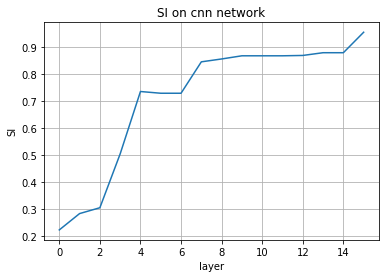

In [90]:
plt.plot(range(len(model_batched.layers)+1) , si)
plt.grid()
plt.title('SI on cnn network')
plt.xlabel('layer')
plt.ylabel('SI')